In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy

def kalman_filter(z, Q, R, x0=0.0, P0=1.0, v=1):
    n = len(z)
    x_pred = np.zeros(n)
    P_pred = np.zeros(n)
    x_est = np.zeros(n)
    P = np.zeros(n)

    # Initial guesses
    x_est[0] = x0
    P[0] = P0

    for k in range(1, n):
        # Predict
        x_pred[k] = x_est[k-1] + v
        P_pred[k] = P[k-1] + Q

        # Update
        K = P_pred[k] / (P_pred[k] + R)
        x_est[k] = x_pred[k] + K * (z[k] - x_pred[k])
        P[k] = (1 - K) * P_pred[k]

    return x_est, P, x_pred, P_pred

# How to estimate the Q and R matrices?
* What are Q and R?
* Method to estimate Q and R
* Validation of estimations
* Conclusions


# Kalman filter
$\hat{x}$ = estimated state of the system

$P$ = corresponding uncertainty
![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Basic_concept_of_Kalman_filtering.svg/960px-Basic_concept_of_Kalman_filtering.svg.png?20140221113919)


## **Update step** in the Kalman filter

![](https://raw.githubusercontent.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/04b2bea802321086effbd99402fc13c893d11110/figs/residual_chart.png)

**Definitions**:
* **Innovation**: difference between the actual measurement and the predicted measurement based on the current state estimate (often called residual)
* **Residual**: difference between the true state and the estimated state

**How much weight to give to the model prediction and to the measurement?**

Q -> decides the weight to put on the model prediction

R -> decides the weight to put on the measurement

## Q and R are Noise Covariance Matrices

|  | $Q \in \mathbb{R}^{n \times n}$   | $R \in \mathbb{R}^{m \times m}$  |
|---|---|---|
||**Process Noise** Covariance Matrix|**Measurement Noise** Covariance Matrix|
| |n  = number of state variables | m = number of measurements |
|**Represents**| uncertainty in the model's prediction | uncertainty in the sensor measurements |
| **High value** | Low model trust | Low measurements trust|
| **Low value** | High model trust | High measurements trust|

---

### Why Are They Important?
The performance of the Kalman filter heavily depends on accurate estimation of Q and R:
* **Underestimating** noise → filter becomes overconfident and diverges.
* **Overestimating** noise → filter becomes sluggish and less responsive.

## A simple example
We observe the position of an object moving with constant mean velocity

We assume that we know:
* the process noise $\mathcal{N}(0,Q)=\mathcal{N}(0,1^2)$
* the measurement noise $\mathcal{N}(0,R)=\mathcal{N}(0,2^2)$


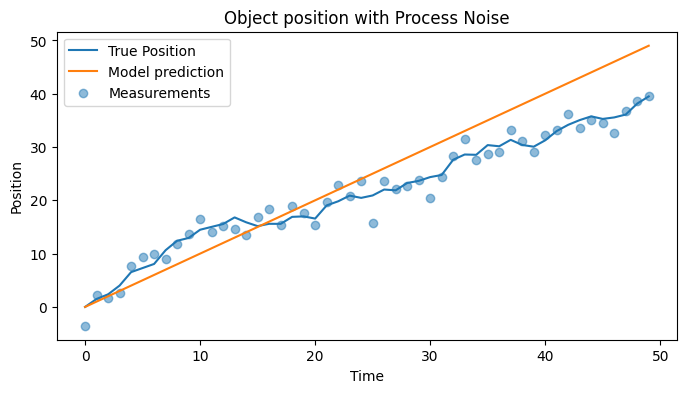

In [ ]:
# Process noise
process_noise_std = 1.0
# Measurements noise
measurement_noise_std = 2.0

time = range(49)
# State Model parameter
mean_vel = 1
x_pred = [0]
for _ in time:
    next_pos = x_pred[-1] + mean_vel
    x_pred.append(next_pos)
# True State with Process Noise
np.random.seed(42)
true_pos = [0]
for _ in time:
    next_pos = true_pos[-1] + mean_vel + np.random.normal(0, process_noise_std)
    true_pos.append(next_pos)
# Measurement
measurements = true_pos + np.random.normal(0, measurement_noise_std, len(true_pos))

# Plot
plt.figure(figsize=(8,4))
plt.plot(true_pos, label='True Position')
plt.plot(x_pred, label='Model prediction')
plt.scatter(range(len(measurements)), measurements, label='Measurements', alpha=0.5)
plt.legend()
plt.title('Object position with Process Noise')
plt.ylabel('Position')
plt.xlabel('Time')
plt.show()


## A simple Example: now predicting with Kalman filter


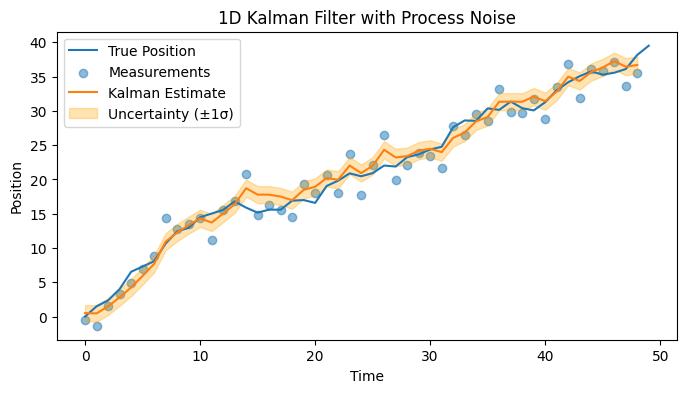

In [ ]:
### Predicting position using Kalman filter
x_estimates = []
x_std_dev = []
measurements = []

# Kalman filter setup
Q_true = process_noise_std**2
R_true = measurement_noise_std**2

# initialization t0
x_est = 0 # guess position at t0
P = 1     # uncertainty on position at t0

for t in time:
    # Predict new position
    x_pred = x_est + mean_vel
    # update uncertainty on the predicted position
    P_pred = P + Q_true

    # Measure position
    z = true_pos[t] + np.random.normal(0, measurement_noise_std)
    measurements.append(z)

    # Update
    residual = z - x_pred         # residual or innovation
    K = P_pred / (P_pred + R_true)     # Kalman gain
    x_est = x_pred + K * residual # new estimated position
    x_estimates.append(x_est)
    P = (1 - K) * P_pred          # uncertainty on the new estimated position
    x_std_dev.append(np.sqrt(P))

# Plot
plt.figure(figsize=(8,4))
plt.plot(true_pos, label='True Position')
plt.scatter(range(len(measurements)), measurements, label='Measurements', alpha=0.5)
plt.plot(x_estimates, label='Kalman Estimate')
lower_bound = [x - s for x, s in zip(x_estimates, x_std_dev)]
upper_bound = [x + s for x, s in zip(x_estimates, x_std_dev)]
plt.fill_between(range(len(x_estimates)), lower_bound, upper_bound, color='orange', alpha=0.3, label='Uncertainty (±1σ)')
plt.legend()
plt.title('1D Kalman Filter with Process Noise')
plt.ylabel('Position')
plt.xlabel('Time')
plt.show()


## Effect of Different Q and R Values

Here we compare the performance of the Kalman filter under different Q and R settings for the 1D case.
- **Low Q, High R**: Filter trusts the model too much.
- **High Q, Low R**: Filter trusts measurements too much.


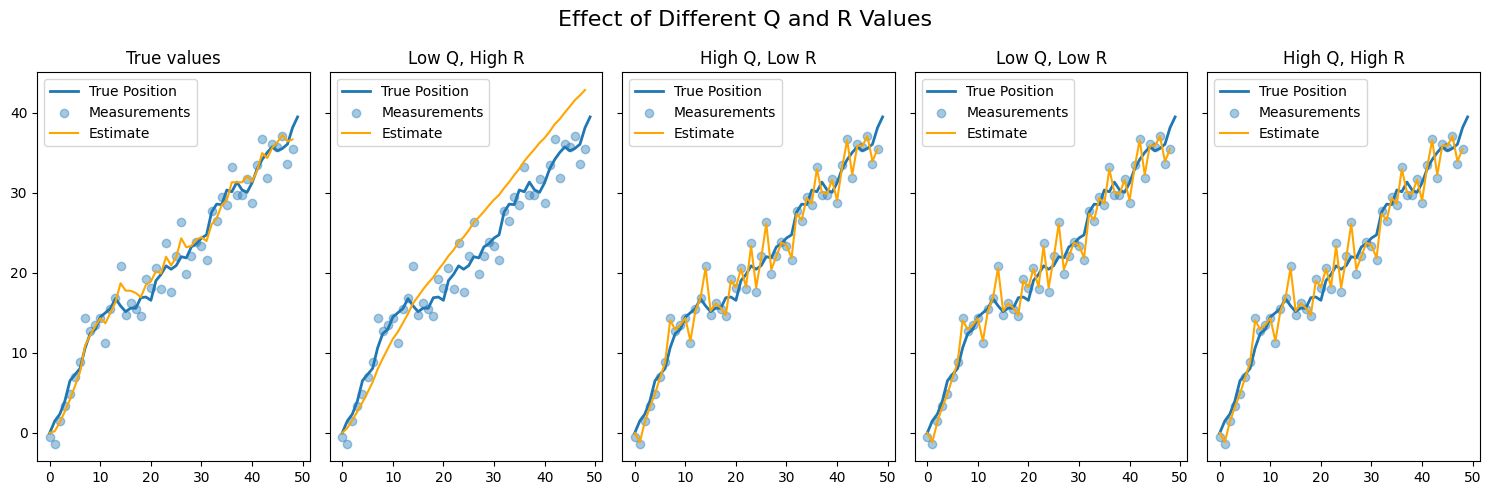

In [16]:
scenarios = [
    {'Q': Q_true, 'R': R_true, 'label': 'True values'},
    {'Q': 0.01, 'R': 5.0, 'label': 'Low Q, High R'},
    {'Q': 6.0, 'R': 0.5, 'label': 'High Q, Low R'},
    {'Q': 12, 'R': 1, 'label': 'Low Q, Low R'},
    {'Q': 18, 'R': 1.5, 'label': 'High Q, High R'}
]

fig, axes = plt.subplots(1, len(scenarios), figsize=(15, 5), sharey=True)

for i, scenario in enumerate(scenarios):
    Q, R = scenario['Q'], scenario['R']
    x0, P = 0, 1
    estimates = kalman_filter(measurements, Q, R, x0=x0, P0=P, v=mean_vel)[0]

    ax = axes[i]
    ax.plot(true_pos, label='True Position', linewidth=2)
    ax.scatter(range(len(measurements)), measurements, label='Measurements', alpha=0.4)
    ax.plot(estimates, label='Estimate', color='orange')
    ax.set_title(scenario['label'])
    ax.legend()

fig.suptitle('Effect of Different Q and R Values', fontsize=16)
plt.tight_layout()
plt.show()


## Methods for estimating Q and R
- Domain knowlegde
- Innovation-Based Estimation
- Loglikelihood
- Expectation Maximization (EM)

### Domain knowledge
Guess Q and R based on knowledge of the system

Our initial guess:
- Q = 0.5
- R = 1.0

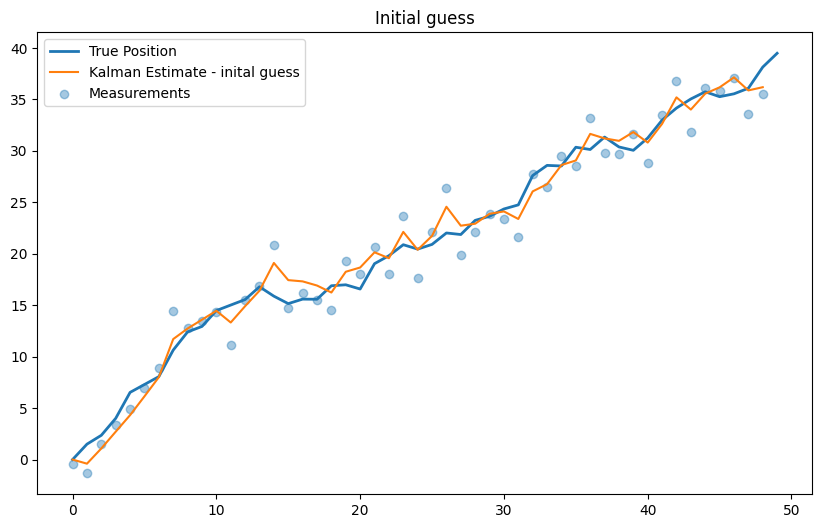

In [ ]:
Q_guess, R_guess = 0.5, 1.0
x_estimates_initial, _, x_pred_initial, _ = kalman_filter(measurements, Q_guess, R_guess, x0=x0, P0=P, v=mean_vel)

plt.figure(figsize=(10,6))
plt.plot(true_pos, label='True Position', linewidth=2)
plt.plot(x_estimates_initial, label='Kalman Estimate - inital guess')
plt.scatter(range(len(measurements)), measurements, label='Measurements', alpha=0.4)
plt.title('Initial guess')
plt.legend()
plt.show()

## Simplified Innovation-Based Estimation of Q and R

### Definitions:
- Innovation: $$y_k = z_k - \hat{x}_{k|k-1}$$
- State correction: $$\delta x_k = \hat{x}_{k|k} - \hat{x}_{k|k-1}$$

### Estimates:
$$
\hat{R} \approx \text{Var}(y_k)
$$
$$
\hat{Q} \approx \text{Var}(\delta x_k)
$$

### Notes:
- Assumes filter is stable and system is stationary.
- Useful for quick tuning or initialization.

Innovation-based estimates: Q=1.833, R=7.140


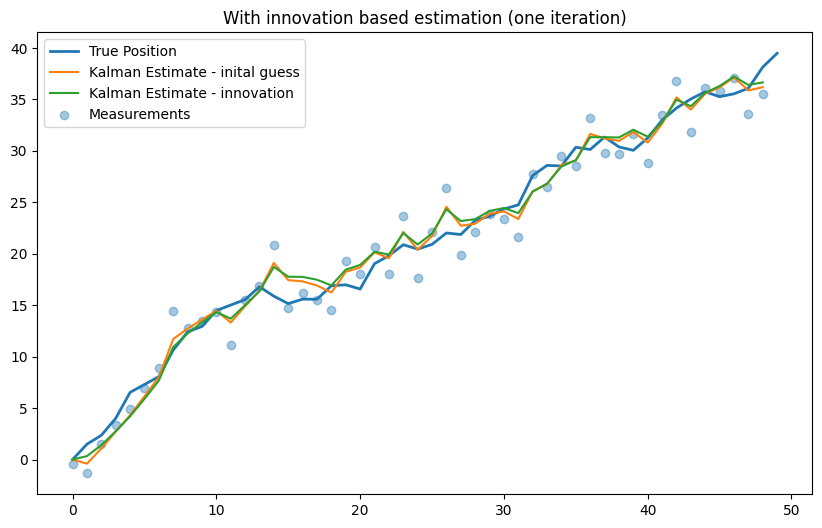

In [ ]:

innovations = measurements-x_pred_initial
R_est = np.var(innovations)
Q_est = np.var(np.diff(x_estimates_initial)-mean_vel)
print(f"Innovation-based estimates: Q={Q_est:.3f}, R={R_est:.3f}")

# run estimation
x_estimates_innovation = kalman_filter(measurements, Q_est, R_est, x0=x0, P0=P, v=mean_vel)[0]

plt.figure(figsize=(10,6))
plt.plot(true_pos, label='True Position', linewidth=2)
plt.plot(x_estimates_initial, label='Kalman Estimate - inital guess')
plt.plot(x_estimates_innovation, label='Kalman Estimate - innovation')
plt.scatter(range(len(measurements)), measurements, label='Measurements', alpha=0.4)
plt.title('With innovation based estimation (one iteration)')
plt.legend()
plt.show()

### Iterative innovation based estimation

EM estimates: Q=0.241, R=7.140


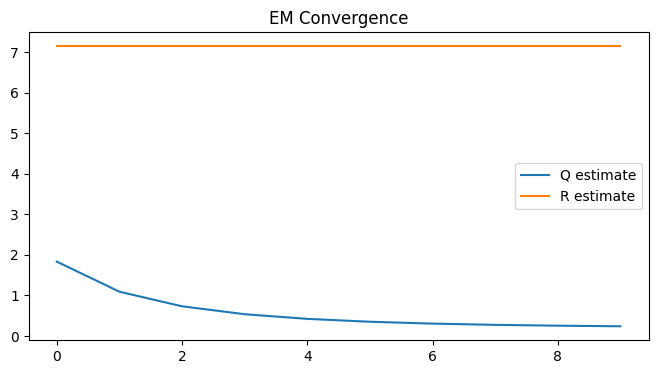

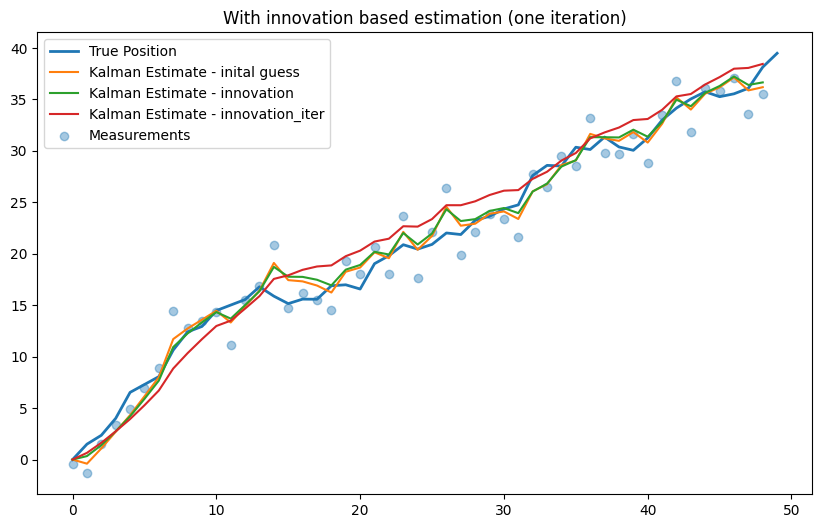

In [ ]:
iterations = 10
Q_est, R_est = Q_guess, R_guess
Q_history, R_history = [], []

for i in range(iterations):
    x_est, P = 0, 1
    x_estimates_, _, x_pred_, _ = kalman_filter(measurements, Q_est, R_est, x0=x0, P0=P, v=mean_vel)
    innovations_ = measurements-x_pred_
    R_est = np.var(innovations)
    Q_est = np.var(np.diff(x_estimates_)-mean_vel)
    Q_history.append(Q_est)
    R_history.append(R_est)

print(f"EM estimates: Q={Q_est:.3f}, R={R_est:.3f}")
plt.figure(figsize=(8,4))
plt.plot(Q_history, label='Q estimate')
plt.plot(R_history, label='R estimate')
plt.title('EM Convergence')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(true_pos, label='True Position', linewidth=2)
plt.plot(x_estimates_initial, label='Kalman Estimate - inital guess')
plt.plot(x_estimates_innovation, label='Kalman Estimate - innovation')
plt.plot(x_estimates_, label='Kalman Estimate - innovation_iter')
plt.scatter(range(len(measurements)), measurements, label='Measurements', alpha=0.4)
plt.title('With innovation based estimation (one iteration)')
plt.legend()
plt.show()

## Maximum Likelihood Estimation (MLE) for Q and R

**Goal:**  
Find Q and R that maximize the likelihood of observed measurements given the Kalman filter model.

---

### Steps:
1. **Define the likelihood**  
   For Gaussian systems, the likelihood is based on the innovation sequence:
   $$
   y_k = z_k - \hat{x}_{k|k-1}, \quad S_k = P_{k|k-1} + R
   $$

2. **Log-likelihood function**  
   $$
   \log \mathcal{L}(Q,R) = -\frac{1}{2} \sum_{k=1}^N \left[ \log |S_k| + y_k^T S_k^{-1} y_k \right]
   $$

3. **Compute innovations**  
   Run Kalman filter with candidate Q and R, collect:
   - Innovations $( y_k )$
   - Innovation covariances $( S_k $)

4. **Optimize Q and R**  
   - **Grid search** or **numerical optimization** to maximize log-likelihood.



In [ ]:
from scipy.optimize import minimize
def neg_loglike(Q, R, z, drift=1.0):
    n = len(z)
    x_pred = 0.0
    P_pred = 1.0
    neglog = 0.0

    for k in range(n):
        S = P_pred + R
        if S <= 0:
            return np.inf
        y = z[k] - x_pred
        neglog += 0.5 * (np.log(2 * np.pi) + np.log(S) + (y**2) / S)

        # Kalman update
        K = P_pred / S
        x_filt = x_pred + K * y
        P_filt = (1 - K) * P_pred

        # Predict next
        x_pred = x_filt + drift
        P_pred = P_filt + Q
    return neglog


# --- Fit via numerical optimization (in log-space) ---
def neg_loglike_logparams(params_log, z, drift=1.0):
    logQ, logR = params_log
    Q = np.exp(logQ)
    R = np.exp(logR)
    return neg_loglike(Q, R, z, drift)

init_log = np.log([0.5, 1.0])
res = minimize(lambda p: neg_loglike_logparams(p, measurements, drift=mean_vel),
               x0=init_log,
               method='Powell',
               options={'disp': False})

opt_logQ, opt_logR = res.x
Q_mle = np.exp(opt_logQ)
R_mle = np.exp(opt_logR)




# # --- Likelihood surface computation ---
# def plot_loglik_surface(z, drift, Q_range, R_range, true_Q, true_R, mle_Q, mle_R):
#     Q_grid = np.linspace(Q_range[0], Q_range[1], 60)
#     R_grid = np.linspace(R_range[0], R_range[1], 60)
#     LL = np.zeros((len(Q_grid), len(R_grid)))

#     for i, Q in enumerate(Q_grid):
#         for j, R in enumerate(R_grid):
#             LL[i, j] = -neg_loglike(Q, R, z, drift)  # log-likelihood = -negloglike

#     plt.figure(figsize=(8, 6))
#     cs = plt.contourf(R_grid, Q_grid, LL, levels=30, cmap='viridis')
#     plt.colorbar(cs, label='Log-likelihood')

#     plt.scatter(true_R, true_Q, color='red', label='True (R,Q)', s=80, edgecolor='k')
#     plt.scatter(mle_R, mle_Q, color='white', label='MLE (R,Q)', s=80, edgecolor='k')

#     plt.xlabel("Measurement noise variance R")
#     plt.ylabel("Process noise variance Q")
#     plt.title("Log-likelihood surface for (Q, R)")
#     plt.legend()
#     plt.grid(alpha=0.4)
#     plt.show()


# # --- Plot likelihood surface ---
# plot_loglik_surface(
#     z=measurements,
#     drift=mean_vel,
#     Q_range=(0.1, 4.0),
#     R_range=(0.5, 5.0),
#     true_Q=Q_true,
#     true_R=R_true,
#     mle_Q=Q_mle,
#     mle_R=R_mle
# )


True Q: 1.0000, Estimated Q (MLE): 1.4108
True R: 4.0000, Estimated R (MLE): 4.1494


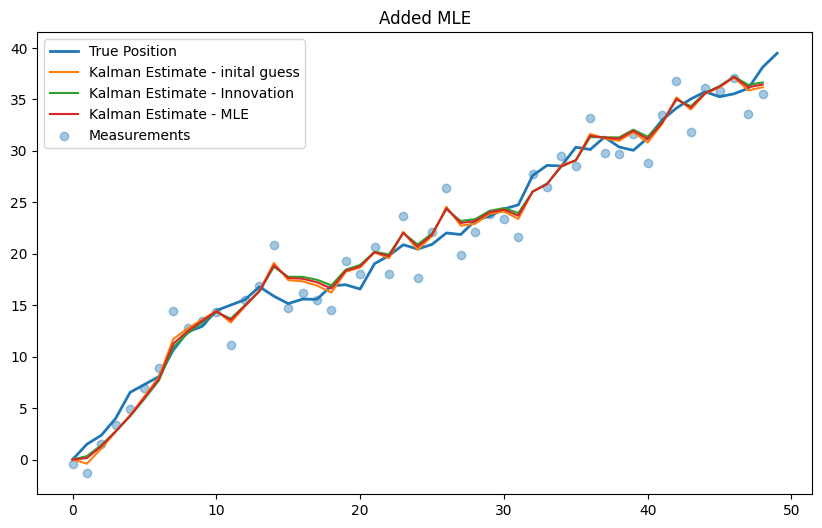

In [ ]:
# run estimation
print(f"True Q: {Q_true:.4f}, Estimated Q (MLE): {Q_mle:.4f}")
print(f"True R: {R_true:.4f}, Estimated R (MLE): {R_mle:.4f}")
x_estimates_MLE = kalman_filter(measurements, Q_mle, R_mle, x0=x0, P0=P, v=mean_vel)[0]

plt.figure(figsize=(10,6))
plt.plot(true_pos, label='True Position', linewidth=2)
plt.plot(x_estimates_initial, label='Kalman Estimate - inital guess')
plt.plot(x_estimates_innovation, label='Kalman Estimate - Innovation')
plt.plot(x_estimates_MLE, label='Kalman Estimate - MLE')
plt.scatter(range(len(measurements)), measurements, label='Measurements', alpha=0.4)
plt.title('Added MLE')
plt.legend()
plt.show()

## Expectation-Maximization (EM) for Q and R

**Goal:**  
Estimate Q and R by maximizing the *expected log-likelihood* of observed data given the Kalman model.

---

### Steps:
1. **Initialize Q and R**  
   Start with reasonable guesses.

2. **E-step (Expectation)**  
   - Run Kalman filter **and smoother** (RTS smoother).
   - Compute expected state transitions and measurement residuals:
     $$
     \mathbb{E}[(x_k - F x_{k-1} - B u_k)(x_k - F x_{k-1} - Bu_k)^T],
     $$
     
     $$
     \mathbb{E}[(z_k - H x_k)(z_k - H x_k)^T]
     $$

3. **M-step (Maximization)**  
   Update Q and R:
   $$
   Q = \frac{1}{N-1} \sum_{k=1}^{N-1} \mathbb{E}[(x_k - F x_{k-1} - B u_k)(x_k - F x_{k-1} - B u_k)^T]
   $$
   $$
   R = \frac{1}{N} \sum_{k=1}^{N} \mathbb{E}[(z_k - H x_k)(z_k - H x_k)^T]
   $$

4. **Iterate until convergence**  
   Q and R stabilize after several iterations.



## For our 1-d example

$$
x_k = x_{k-1} + u + w_k, \quad w_k \sim \mathcal{N}(0, Q)
$$

$$
z_k = x_k + v_k, \quad v_k \sim \mathcal{N}(0, R)
$$


---

### E-Step (Expectation)

Given current parameter estimates $Q^{(i)}, R^{(i)}$:

- Run the **Kalman filter** (forward pass)  
  to compute filtered means and variances $(x_{k|k}, P_{k|k})$.

- Run the **RTS smoother** (backward pass)  
  to obtain smoothed estimates:
  $$
  \hat{x}_k = E[x_k \mid z_{1:T}], \quad
  P_k = \text{Var}[x_k \mid z_{1:T}], \quad
  P_{k,k-1} = \text{Cov}[x_k, x_{k-1} \mid z_{1:T}]
  $$

---

### M-Step (Maximization)

Update $Q$ and $R$ using the smoothed statistics:

$$
Q^{(i+1)} =
\frac{1}{T-1} \sum_{k=1}^{T-1}
\left[
(\hat{x}_{k+1} - \hat{x}_k - u)^2
+ P_{k+1} + P_k - 2P_{k+1,k}
\right]
$$

$$
R^{(i+1)} =
\frac{1}{T} \sum_{k=1}^{T}
\left[
(z_k - \hat{x}_k)^2 + P_k
\right]
$$




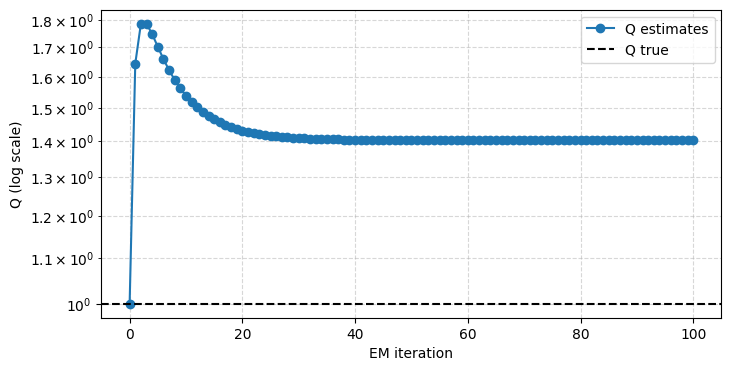

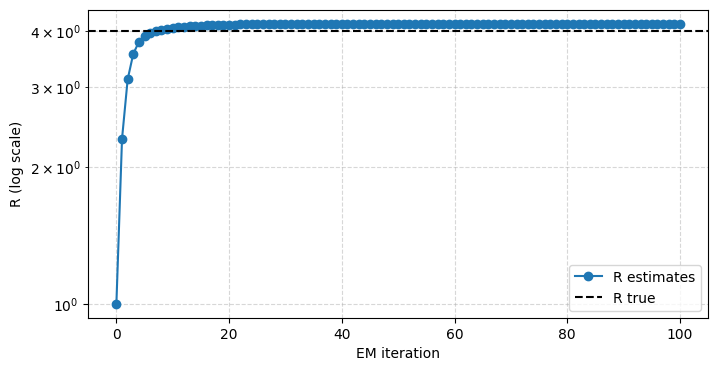

In [ ]:
def rts_smoother_scalar(x_filt, P_filt, x_pred, P_pred, Q):
    n = len(x_filt)
    x_smooth = np.copy(x_filt)
    P_smooth = np.copy(P_filt)
    P_cross = np.zeros(n)

    for k in range(n - 2, -1, -1):
        C = 0.0 if P_pred[k+1] == 0 else P_filt[k] / P_pred[k+1]
        x_smooth[k] = x_filt[k] + C * (x_smooth[k+1] - x_pred[k+1])
        P_smooth[k] = P_filt[k] + C * (P_smooth[k+1] - P_pred[k+1]) * C
        P_cross[k+1] = C * P_smooth[k+1]
    return x_smooth, P_smooth, P_cross

# --- EM algorithm ---
def em_estimate_QR(z, v, Q_init=1.0, R_init=1.0, x0=0.0, P0=1.0, max_iter=100, tol=1e-6, verbose=False):
    Q = float(Q_init)
    R = float(R_init)
    n = len(z)
    history = {'Q': [], 'R': []}

    for it in range(max_iter):
        history['Q'].append(Q)
        history['R'].append(R)
        x_filt, P_filt, x_pred, P_pred = kalman_filter(z, Q, R, x0=x0, P0=P0, v=v)
        x_smooth, P_smooth, P_cross = rts_smoother_scalar(x_filt, P_filt, x_pred, P_pred, Q)

        # M-step for Q
        sum_Q = 0.0
        for k in range(n-1):
            mean_diff = x_smooth[k+1] - x_smooth[k] - v
            var_diff = P_smooth[k+1] + P_smooth[k] - 2 * P_cross[k+1]
            sum_Q += mean_diff**2 + var_diff
        Q_new = sum_Q / (n - 1)

        # M-step for R
        sum_R = 0.0
        for k in range(n):
            res = z[k] - x_smooth[k]
            sum_R += res**2 + P_smooth[k]
        R_new = sum_R / n

        if verbose:
            print(f"Iter {it+1:3d}: Q={Q:.6f} -> {Q_new:.6f}, R={R:.6f} -> {R_new:.6f}")

        if abs(Q_new - Q) < tol*(1+abs(Q)) and abs(R_new - R) < tol*(1+abs(R)):
            Q, R = Q_new, R_new
            history['Q'].append(Q); history['R'].append(R)
            break

        Q, R = Q_new, R_new

    # final smoothing with converged params
    x_filt, P_filt, x_pred, P_pred = kalman_filter(z, Q, R, x0=x0, P0=P0, v=v)
    x_smooth, P_smooth, P_cross = rts_smoother_scalar(x_filt, P_filt, x_pred, P_pred, Q)
    return Q, R, x_smooth, P_smooth, P_cross, history

# --- Run EM ---
Q_init = 1.0
R_init = 1.0
Q_em, R_em, x_smooth_em, P_smooth_em, P_cross_em, hist = em_estimate_QR(
    measurements, v=mean_vel, Q_init=Q_init, R_init=R_init, x0=0.0, P0=1.0, max_iter=200, tol=1e-8, verbose=False
)



# --- Plots ---
plt.figure(figsize=(8,4))
plt.plot(hist['Q'], marker='o', label='Q estimates')
plt.axhline(Q_true, color='k', linestyle='--', label='Q true')
plt.yscale('log')
plt.xlabel('EM iteration')
plt.ylabel('Q (log scale)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(hist['R'], marker='o', label='R estimates')
plt.axhline(R_true, color='k', linestyle='--', label='R true')
plt.yscale('log')
plt.xlabel('EM iteration')
plt.ylabel('R (log scale)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()




True Q = 1.0000, EM estimated Q = 1.4029
True R = 4.0000, EM estimated R = 4.1459


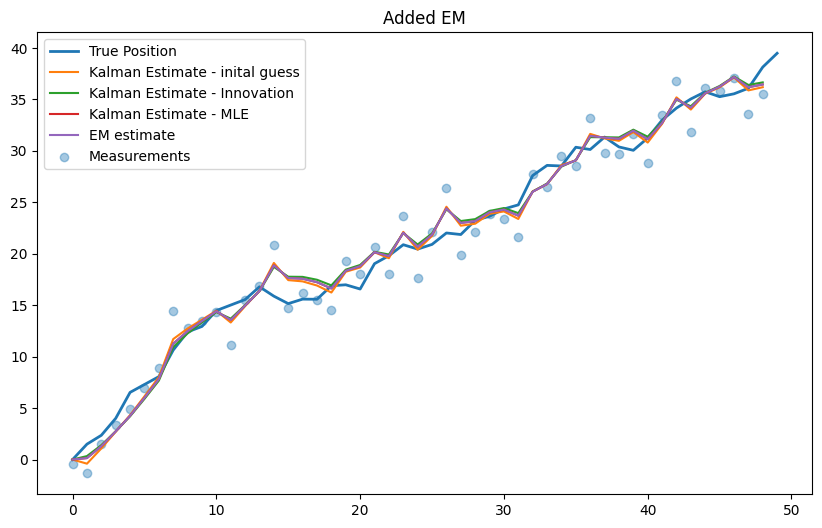

In [ ]:
print(f"\nTrue Q = {Q_true:.4f}, EM estimated Q = {Q_em:.4f}")
print(f"True R = {R_true:.4f}, EM estimated R = {R_em:.4f}")
x_estimates_EM = kalman_filter(measurements, Q_em, R_em, x0=x0, P0=P, v=mean_vel)[0]
plt.figure(figsize=(10,6))
plt.plot(true_pos, label='True Position', linewidth=2)
plt.plot(x_estimates_initial, label='Kalman Estimate - inital guess')
plt.plot(x_estimates_innovation, label='Kalman Estimate - Innovation')
plt.plot(x_estimates_MLE, label='Kalman Estimate - MLE')
plt.plot(x_estimates_EM, label='EM estimate')
plt.scatter(range(len(measurements)), measurements, label='Measurements', alpha=0.4)
plt.title('Added EM')
plt.legend()
plt.show()


#VALIDATION

In [ ]:
import numpy as np
from math import log
from scipy.stats import chi2

def run_filter_get_innov(z, Q, R, v=1.0, x0=0.0, P0=1.0):
    x_est, P, x_pred, P_pred = kalman_filter(z, Q, R, x0=x0, P0=P0, v=v)
    innovations = z - x_pred
    S = P_pred + R                  # innovation variance (1D)
    return x_est, P, x_pred, P_pred, innovations, S

def metrics_innov(z, Q, R, v=1.0):
    x_est, P, x_pred, P_pred, innov, S = run_filter_get_innov(z, Q, R, v)
    # 1) prediction & likelihood
    rmse_pred = np.sqrt(np.mean((z - x_pred)**2))
    loglik = -0.5*np.sum(np.log(2*np.pi*S) + (innov**2)/S)

    # 2) innovation stats
    mu = float(np.mean(innov))
    var = float(np.var(innov, ddof=1))

    # simple whiteness proxy: lag-1 autocorr
    r1 = np.corrcoef(innov[1:], innov[:-1])[0,1]

    # 3) NIS coverage (95% two-sided band using chi-square with 1 dof)
    NIS = (innov**2)/S
    alpha = 0.95
    lo, hi = chi2.ppf((1-alpha)/2, df=1), chi2.ppf(1-(1-alpha)/2, df=1)
    coverage = np.mean((NIS >= lo) & (NIS <= hi))

    return {
        "rmse_pred": rmse_pred,
        "loglik": loglik,
        "innov_mean": mu,
        "innov_var": var,
        "lag1_autocorr": r1,
        "NIS_coverage": coverage
    }

def sensitivity_scan(z, Q_hat, R_hat, v=1.0, scales=(0.5, 0.75, 1.0, 1.25, 2.0)):
    rows = []
    for sQ in scales:
        for sR in scales:
            m = metrics_innov(z, Q_hat*sQ, R_hat*sR, v)
            rows.append({"sQ": sQ, "sR": sR, **m})
    return rows


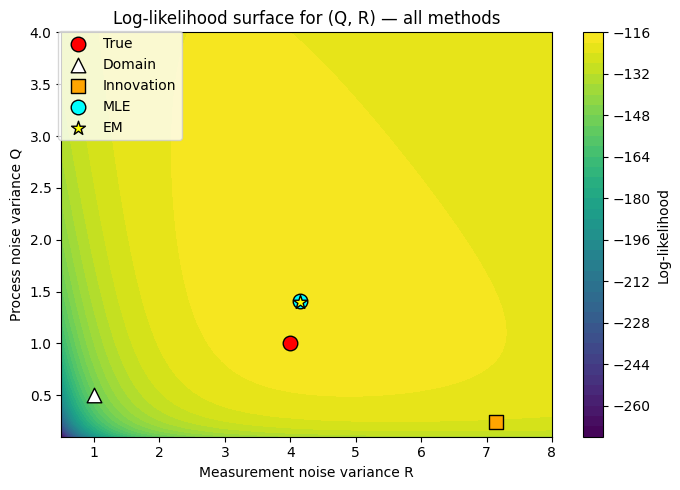

In [ ]:
# --- Log-likelihood surface with all 4 methods overlaid ---

import numpy as np
import matplotlib.pyplot as plt

# Helper: compute log-likelihood at given (Q, R) using your existing functions
def loglik_QR(z, Q, R, v=1.0):
    m = metrics_innov(z, Q, R, v)  # uses the helper we added earlier
    return m["loglik"]

def plot_loglik_surface_all(
    z,
    drift,
    Q_range=(0.1, 4.0),
    R_range=(0.5, 5.0),
    nQ=80,
    nR=80,
    points=None,   # list of (label, R, Q, style_dict)
    title="Log-likelihood surface for (Q, R)"
):
    Qs = np.linspace(Q_range[0], Q_range[1], nQ)
    Rs = np.linspace(R_range[0], R_range[1], nR)
    L = np.empty((nQ, nR))

    # Build the surface
    for i, Q in enumerate(Qs):
        for j, R in enumerate(Rs):
            L[i, j] = loglik_QR(z, Q, R, v=drift)

    # Plot
    fig, ax = plt.subplots(figsize=(7,5))
    cf = ax.contourf(Rs, Qs, L, levels=40, cmap="viridis")
    cbar = fig.colorbar(cf, ax=ax)
    cbar.set_label("Log-likelihood")

    ax.set_title(title)
    ax.set_xlabel("Measurement noise variance R")
    ax.set_ylabel("Process noise variance Q")

    # Overlay points (R on x, Q on y)
    if points:
        for label, Rv, Qv, style in points:
            ax.scatter(Rv, Qv, s=110, zorder=3, label=label, **style)

    ax.legend(
    loc="upper left",
    bbox_to_anchor=(-0.02, 1.02),   # move it slightly outside the axes
    frameon=True
)

    plt.tight_layout()
    plt.show()

# ---- Collect the four method estimates (adjust names if yours differ) ----
# Domain-knowledge guess
R_domain = R_guess
Q_domain = Q_guess

# Innovation-based estimate
R_innov  = R_est
Q_innov  = Q_est

# MLE
R_mle_   = R_mle
Q_mle_   = Q_mle

# EM
R_em_    = R_em
Q_em_    = Q_em

# (Optional) True values if you’re on synthetic data;
# wrap in try/except in case they’re not defined.
pts = []
try:
    pts.append(("True", R_true, Q_true, dict(marker="o", c="red", edgecolors="k")))
except Exception:
    pass

pts.extend([
    ("Domain",     R_domain, Q_domain, dict(marker="^", c="white", edgecolors="k")),
    ("Innovation", R_innov,  Q_innov,  dict(marker="s", c="orange", edgecolors="k")),
    ("MLE",        R_mle_,   Q_mle_,   dict(marker="o", c="cyan", edgecolors="k")),
    ("EM",         R_em_,    Q_em_,    dict(marker="*", c="yellow", edgecolors="k")),
])

# ---- Draw the surface with all points overlaid ----
plot_loglik_surface_all(
    z=measurements,
    drift=mean_vel,
    Q_range=(0.1, 4.0),
    R_range=(0.5, 8.0),   # or bigger than your largest R estimate
    nQ=100,
    nR=120,
    points=pts,
    title="Log-likelihood surface for (Q, R) — all methods"
)




In [ ]:
results = {}

# Domain knowledge guess
results["domain"] = metrics_innov(measurements, Q_guess, R_guess, v=mean_vel)

# Innovation-based (single-shot)
results["innovation"] = metrics_innov(measurements, Q_est, R_est, v=mean_vel)

# MLE
results["mle"] = metrics_innov(measurements, Q_mle, R_mle, v=mean_vel)

# EM
results["em"]  = metrics_innov(measurements, Q_em,  R_em,  v=mean_vel)

print("\n=== Validation summary (higher loglik better; rmse/|lag1| closer to 0 better; NIS≈0.95) ===")
for k,v in results.items():
    print(k, v)

import pandas as pd
pd.options.display.float_format = "{:,.3f}".format  # round to 3 decimals

# Convert to a clean table
df_results = pd.DataFrame(results).T
df_results = df_results[[
    "rmse_pred", "loglik", "innov_mean", "innov_var",
    "lag1_autocorr", "NIS_coverage"
]]

print("=== Validation Summary (higher loglik better; RMSE & |lag1| closer to 0 better; NIS≈0.95) ===")
display(df_results.style.set_caption("Kalman Filter Q/R Estimation Validation")
                     .set_table_styles([{'selector':'caption','props':[('caption-side','top'),
                                                                      ('font-size','16px'),
                                                                      ('font-weight','bold')]}])
                     .background_gradient(cmap="coolwarm", subset=["loglik"])
                     .format(precision=3))




=== Validation summary (higher loglik better; rmse/|lag1| closer to 0 better; NIS≈0.95) ===
domain {'rmse_pred': np.float64(2.7154378433414608), 'loglik': np.float64(-151.90003410182067), 'innov_mean': -0.4832858978376544, 'innov_var': 7.288788201627221, 'lag1_autocorr': np.float64(-0.1901547406102676), 'NIS_coverage': np.float64(0.7346938775510204)}
innovation {'rmse_pred': np.float64(3.080217560816057), 'loglik': np.float64(-124.67540015914184), 'innov_mean': -1.1642335274499356, 'innov_var': 8.301723442927788, 'lag1_autocorr': np.float64(0.2553799850623872), 'NIS_coverage': np.float64(0.9795918367346939)}
mle {'rmse_pred': np.float64(2.699343550287989), 'loglik': np.float64(-117.8713030315848), 'innov_mean': -0.5550400818178067, 'innov_var': 7.123769154016567, 'lag1_autocorr': np.float64(-0.13570372409043638), 'NIS_coverage': np.float64(0.9795918367346939)}
em {'rmse_pred': np.float64(2.6993231713581807), 'loglik': np.float64(-117.87115501897227), 'innov_mean': -0.555792442190689, 

,rmse_pred,loglik,innov_mean,innov_var,lag1_autocorr,NIS_coverage
domain,2.715,-151.900,-0.483,7.289,-0.190,0.735
innovation,3.080,-124.675,-1.164,8.302,0.255,0.980
mle,2.699,-117.871,-0.555,7.124,-0.136,0.980
em,2.699,-117.871,-0.556,7.123,-0.135,0.980


#Recap

**The role of Q and R matrices**

![](https://raw.githubusercontent.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/04b2bea802321086effbd99402fc13c893d11110/figs/residual_chart.png)

Q decides weight on prediction, R decides weight on measurement
***

**Methods for estimating Q and R**
- Domain knowlegde - Best guess based on expertise
- Innovation-Based Estimation - Estimates based on variance in prediction and innovations
- Maximum likelihood - Find best candidates with grid search or numerical optimization
- Expectation Maximization - Iterate back and forth until Q and R converges below a threshold
***

**Suggested procedure**
1. Make a guess
2. Refine using statistical method on historical data
3. Validate

**Further reading**
- Merha's approach (https://www.sciencedirect.com/science/article/pii/S0005109805003262)
- Autocovariance least-squares (ALS) technique (https://www.sciencedirect.com/science/article/abs/pii/S000510980800366X?via%3Dihub)
- Field Kalman Filter (https://doi.org/10.1109/CDC.2016.7798697)
- Optimized Kalman Filter (https://proceedings.neurips.cc/paper_files/paper/2023/file/9dfcc83c01e94d02c751c47517855c9f-Paper-Conference.pdf)